In [11]:
try: # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
  from google.colab import drive
except Exception:
  pass
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
!pip install scikit-commpy
import commpy
import time

seed_val = 314159


# for hosted runtimes, uncomment:
drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Colab Notebooks/SASM/Models'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
def vec_bin_array(arr, m):
    """
    Arguments: 
    arr: Numpy array of positive integers
    m: Number of bits of each integer to retain

    Returns a copy of arr with every element replaced with a bit vector.
    Bits encoded as int8's.
    """
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))
    strs = to_str_func(arr)
    ret = np.zeros(list(arr.shape) + [m], dtype=np.int8)
    for bit_ix in range(0, m):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        ret[...,bit_ix] = fetch_bit_func(strs).astype("int8")

    return ret

System Parameters

In [13]:
#@title Set variables and load data
modulation_order =  2#@param {type:"raw"}
ifft_length = 64 #@param {type:"slider", min:32, max:128, step:1}
num_keys =  10#@param {type:"integer"}
train_samples = 250 #@param {type:"slider", min:10, max:1000, step:10}
exceeta =  32#@param {type:"integer"}
snr_db =  10#@param {type:"integer"}
alpha =  0.2#@param {type:"number"}

ma = modulation_order
modem = commpy.modulation.QAMModem(2**(ma))
num_of_chunks = exceeta


codeword=np.zeros((num_keys,ifft_length))
np.random.seed(1)
for i in range(0,num_keys):
    A=np.random.randint(2, size=(1, num_of_chunks)) 
    C=np.repeat(A,ifft_length/num_of_chunks)
    codeword[i]=2*C-1
    
# Paths to load each model
NN_model_path = model_dir + '/NN/keys_' + str(num_keys) + '_snr_' + str(snr_db) + '_range_' + str(alpha) + '_exceeta_' + str(exceeta) + '_ifft_' + str(ifft_length) + '_samples_' + str(train_samples) + '.h5'
SVM_model_path = model_dir + '/SVM/keys_' + str(num_keys) + '_snr_' + str(snr_db) + '_range_' + str(alpha) + '_exceeta_' + str(exceeta) + '_ifft_' + str(ifft_length) + '_samples_' + str(train_samples) + '.joblib'
LR_model_path = model_dir + '/LR/keys_' + str(num_keys) + '_snr_' + str(snr_db) + '_range_' + str(alpha) + '_exceeta_' + str(exceeta) + '_ifft_' + str(ifft_length) + '_samples_' + str(train_samples) + '.joblib'

In [14]:
model = tf.keras.models.load_model(NN_model_path)
num_frames = 100

# np.random.seed(int(time.time()))
np.random.seed(seed_val)
bit_streama=np.random.randint(2,size=(num_frames,int(ifft_length/4),ma)) # should this 4 be ma instead?
print(bit_streama.shape)

ax1 = np.size(bit_streama, axis=1)
message_symbols = np.empty((num_frames,ax1,1),dtype=complex)
symba = np.zeros((num_frames,ax1*2,1),dtype=complex)
z=np.array([[0]],dtype=complex)
tx_syma = np.zeros((num_frames, ifft_length, 1),dtype=complex)
ber_classical=np.zeros(31)
ber_key=np.zeros(31)
ber_combined=np.zeros(31)

# Generate ALL the constellations to be used at once
for i in np.arange(num_frames):
  for _ in np.arange(ax1):
    draft=bit_streama[i,_]
    message_symbols[i,_]=modem.modulate(draft)
  for _ in np.arange(ax1, dtype=int):
    symba[i,_*2] = message_symbols[i,_]
  tx_syma[i]=np.concatenate((z,  symba[i,0:int(ifft_length/2)-1],  z,  
                          np.flip(np.conj(symba[i,0:int(ifft_length/2)-1]))))

# perform ifft on ALL the frames (no need for loop) and rectify results
tx_symiffta=np.maximum(0,np.real_if_close(np.fft.ifft(tx_syma, axis=1)))
tx_symiffta = tx_symiffta.reshape(num_frames, ifft_length)

# modulate all signals for each code
tx_symifftfinal = np.zeros((num_keys,num_frames,ifft_length))
for _ in np.arange(num_keys):
  tx_symifftfinal[_] = tx_symiffta
for _ in np.arange(num_keys):
  tx_symifftfinal[_,:,codeword[_]==1] = tx_symifftfinal[_,:,codeword[_]==1]+alpha
  tx_symifftfinal[_,:,codeword[_]==-1] = 1*tx_symifftfinal[_,:,codeword[_]==-1]

tx_reshaped = tx_symifftfinal.reshape(num_frames*num_keys,ifft_length)

# get average power of all frames
power = np.sum(np.square(tx_reshaped.ravel()))/len(tx_reshaped.ravel())
power_db = 10*np.log10(power)

key_bit_order = int(np.ceil(np.log2(num_keys)))
int_arr = np.floor(np.arange(0,num_keys,1/num_frames)).astype('int')
key_bits = vec_bin_array(int_arr, key_bit_order)

(100, 16, 2)


In [15]:
for snr in np.arange(0, 30+1, 1):
  noise_db = power_db - snr
  noise_watts = 10**(noise_db/10)

  print("starting snr ", snr, "db, noise is ",noise_watts," watts and ",noise_db," db")

  
  alpha2 = tx_symifftfinal.reshape(num_keys*num_frames,ifft_length,1) + np.random.normal(0, np.sqrt(noise_watts), (num_keys*num_frames,ifft_length,1))
  predictions = np.zeros((num_keys*num_frames), dtype=int)

  start = time.time()
  predictions = np.argmax(model.predict(alpha2,batch_size=num_keys),axis=1).astype(int)
  elapsed = time.time() - start
  alpha2 = alpha2.reshape((num_keys*num_frames,ifft_length))
  tx_flat = tx_symifftfinal.reshape((num_keys*num_frames,ifft_length))
  rx_reversed = np.zeros((num_keys*num_frames,ifft_length))
  counter = 0
  for _ in np.arange(num_keys*num_frames):
    pred = predictions[_]
    rx_reversed[_,codeword[pred]==1] = (alpha2[_,codeword[pred]==1]-alpha)
    rx_reversed[_,codeword[pred]==-1] = 1*(alpha2[_,codeword[pred]==-1])

 


  start = time.time()
  sym_idx = np.zeros((num_keys*num_frames,int(ifft_length/4)), dtype=complex)
  for _ in np.arange(num_keys*num_frames):
    rx_sym = np.fft.fft(rx_reversed[_])
    sym_idx[_] = 2*rx_sym[1:int(ifft_length/2):2]
  elapsed = time.time() - start

  
  sym_idx = sym_idx.reshape((num_keys*num_frames,int(ifft_length/4),1))
  received_bits=np.empty((len(sym_idx),int(ifft_length/4),ma),dtype=int)
  # Demodulate
  for i in np.arange(num_keys*num_frames):
    for _ in np.arange(int(ifft_length/4)):
      received_bits[i,_] = modem.demodulate(sym_idx[i,_],'hard')
  rec_bits = received_bits.reshape((num_keys, num_frames, int(ifft_length/4), ma))

  errors = 0
  for _ in np.arange(num_keys):
    errors += (bit_streama != rec_bits[_]).sum()
  
  prediction_key = vec_bin_array(predictions, key_bit_order)

  ber_key[snr] = (prediction_key != key_bits).sum()/prediction_key.size
  
  ber_classical[snr] = errors/rec_bits.size

  ber_combined[snr] = ((prediction_key != key_bits).sum() + errors)/(prediction_key.size + rec_bits.size)

np.savetxt(model_dir + "/alpha_" + str(alpha) + "keys_" + str(num_keys) + "eta_" + str(exceeta) + "_classical_BER.csv", ber_classical, delimiter=",")
np.savetxt(model_dir + "/alpha_" + str(alpha) + "keys_" + str(num_keys) + "eta_" + str(exceeta) + "_key_BER.csv", ber_key, delimiter=",")
np.savetxt(model_dir + "/alpha_" + str(alpha) + "keys_" + str(num_keys) + "eta_" + str(exceeta) + "_combined_BER.csv", ber_combined, delimiter=",")

print(ber_classical, ber_key)

starting snr  0 db, noise is  0.03885179323065992  watts and  -14.10588931246405  db
starting snr  1 db, noise is  0.03086107633278288  watts and  -15.10588931246405  db
starting snr  2 db, noise is  0.024513824285110734  watts and  -16.10588931246405  db
starting snr  3 db, noise is  0.019472022770733226  watts and  -17.10588931246405  db
starting snr  4 db, noise is  0.015467177473987542  watts and  -18.10588931246405  db
starting snr  5 db, noise is  0.012286015779079692  watts and  -19.10588931246405  db
starting snr  6 db, noise is  0.009759129225591039  watts and  -20.10588931246405  db
starting snr  7 db, noise is  0.007751951890209873  watts and  -21.10588931246405  db
starting snr  8 db, noise is  0.0061575942606179705  watts and  -22.10588931246405  db
starting snr  9 db, noise is  0.004891150979185039  watts and  -23.10588931246405  db
starting snr  10 db, noise is  0.003885179323065992  watts and  -24.10588931246405  db
starting snr  11 db, noise is  0.0030861076332782877  

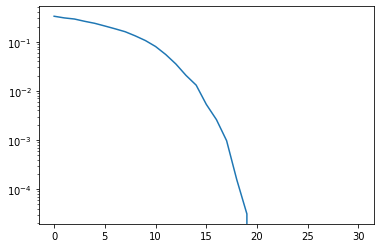

In [16]:
plt.plot(ber_classical)
plt.yscale('log')

9


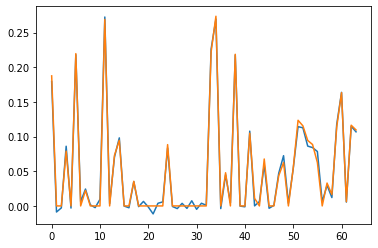

In [17]:
plt.plot(rx_reversed[0])
plt.plot(tx_symiffta[0])
print(pred)


In [18]:
(predictions != int_arr).sum()

0

In [19]:
int_arr.size

1000

In [ ]:
def cal_power(signal):
  dummy5=np.asarray(np.transpose(signal))
  dummy6=dummy5.ravel()
  result=np.zeros(len(dummy6))
  for i in range(len(dummy6)):
           result[i]= dummy6[i] * dummy6[i]
  calculated_power=sum(result)/len(result)
  calculated_power_db=10*np.log10(calculated_power)
  return calculated_power_db

max_snr = 30
min_snr = 0
increment = 1
ber=np.zeros(np.int(np.ceil((max_snr-min_snr+1)/increment)))
np.random.seed(int(time.time()))
for a in range(0, num_frames):
  for j in range(0,num_keys):
      ber_frame=np.zeros(np.int((max_snr-min_snr+1)/increment))
      # plt.figure() 
      bit_streama=np.random.randint(2,size=(int(ifft_length/4),ma)) 
      message_symbols=np.empty([len(bit_streama),1],dtype=complex)
      
      for ii in range(0,len(bit_streama)):  
          draft=bit_streama[ii]
          message_symbols[ii]=modem.modulate(draft.tolist())

      num_of_frames=1
      tx_symaa=message_symbols
      symba=np.zeros([int(ifft_length/2),1],dtype=complex)
      loop=0;

      # Generate ACO-OFDM with zero padding of the first half of the IFFT bins
      for uu in range(0,len(symba),2):
          symba[uu] = tx_symaa[loop];
          loop = loop+1;

      z=np.array([[0]],dtype=complex)
      tx_syma=np.concatenate((z,symba[0:int(ifft_length/2)-1],z,np.flip(np.conj(symba[0:int(ifft_length/2)-1]))))
      tx_symiffta=np.fft.ifft(tx_syma,axis=0)
      
      tx_symiffta[tx_symiffta<0]=0; # convert to unipolar positive

      x_axis=range(ifft_length)
      #plt.plot(list(x_axis),tx_symiffta)
      
      tx_symifftfinal=tx_symiffta;
      aco_sig = np.empty_like(tx_symiffta)
      aco_sig[:,] = tx_symiffta[:,]
      
      # Calculate power before ASM 
      calculated_power=cal_power(tx_symifftfinal)     
  
# ========== Modulate transmitted signal ==========
      # ### This is what we need to reverse
      # dummy=codeword[j,:]
      # tx_symifftfinal[dummy==1]=-1.*tx_symifftfinal[dummy==1]+mcH;
      # tx_symifftfinal[dummy==-1]=1.*tx_symifftfinal[dummy==-1]-mcL;
# ========== End of modulation ==========
      dummy2=np.real(tx_symifftfinal)

      # Calculate power after ASM 
      calculated_power2=cal_power(dummy2)     

      counter=0; # Initializer for ber_frame
      
      for snr_db in range(min_snr,max_snr+1,increment):
        noise_db = calculated_power2 - snr_db
        noise_watts = 10 ** (noise_db / 10)
        # Adding awgn
        dummy3=np.transpose(dummy2)
        dummy3=np.real(dummy3)+np.random.normal(0, np.sqrt(noise_watts), 64)
        dummy3=np.transpose(dummy3) 

        reverse = np.empty_like(dummy3)
        reverse[:,] = dummy3[:,]
# ========== Predict the code + demod ==========
      #   predicted = model.predict_classes(dummy3.reshape(1,64,1))
      #   if predicted == j:
      #     true = true + 1
      #   else:
      #     false = false + 1  
# ========== End of prediction ==========
      # Now Detection!
        zRx=reverse
        rx_sym=np.fft.fft(zRx,axis=0)
        sym_idx = 2*rx_sym[1:int(ifft_length/2):2];
        #print(sym_idx)
        received_bits=np.empty([len(sym_idx),ma],dtype=int)

        #received_bits=list() # Trying to convert into list to adapt to new regulations, leaving it for now!
            
        for ii in range(0,len(received_bits)):  
            received_bits[ii]=modem.demodulate(sym_idx[ii],'hard')
                    
        errors = (bit_streama != received_bits).sum()
        numrows = len(received_bits)    
        numcols = len(received_bits[0]) 
        err_rate=errors/(numrows*numcols)
        ber_frame[counter]=err_rate
        counter=counter+1
      
      ber=ber+ber_frame

avg_ber=ber/num_frames/num_keys
np.savetxt(model_dir + "/alpha_" + str(alpha) + "_no_asm_BER.csv", avg_ber, delimiter=",")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  
